In [1]:
import os

for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        print(os.path.join(root, file))


/kaggle/input/cmapss-jet-engine-simulated-data/RUL_FD002.txt
/kaggle/input/cmapss-jet-engine-simulated-data/test_FD003.txt
/kaggle/input/cmapss-jet-engine-simulated-data/Damage Propagation Modeling.pdf
/kaggle/input/cmapss-jet-engine-simulated-data/readme.txt
/kaggle/input/cmapss-jet-engine-simulated-data/train_FD003.txt
/kaggle/input/cmapss-jet-engine-simulated-data/test_FD004.txt
/kaggle/input/cmapss-jet-engine-simulated-data/train_FD004.txt
/kaggle/input/cmapss-jet-engine-simulated-data/test_FD002.txt
/kaggle/input/cmapss-jet-engine-simulated-data/train_FD001.txt
/kaggle/input/cmapss-jet-engine-simulated-data/train_FD002.txt
/kaggle/input/cmapss-jet-engine-simulated-data/RUL_FD001.txt
/kaggle/input/cmapss-jet-engine-simulated-data/RUL_FD004.txt
/kaggle/input/cmapss-jet-engine-simulated-data/RUL_FD003.txt
/kaggle/input/cmapss-jet-engine-simulated-data/test_FD001.txt


In [2]:
import pandas as pd

# CMAPSS column names (official)
cols = (['engine_id', 'cycle',
        'op_setting_1', 'op_setting_2', 'op_setting_3'] + 
       [f'sensor_{i}' for i in range(1, 22)])

train_path = '/kaggle/input/cmapss-jet-engine-simulated-data/train_FD001.txt'

df = pd.read_csv(train_path, sep=' ', header=None)
df.drop(columns=df.columns[-2:], inplace=True)  # remove extra spaces
df.columns = cols

df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
print("Shape:", df.shape)
print("\nNumber of engines:", df['engine_id'].nunique())
print("\nCycles per engine (first 5):")
df.groupby('engine_id')['cycle'].max().head()


Shape: (20631, 26)

Number of engines: 100

Cycles per engine (first 5):


engine_id
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64

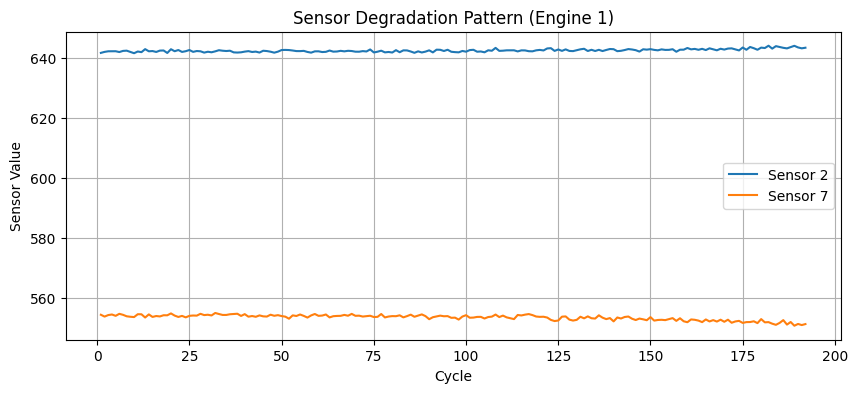

In [4]:
import matplotlib.pyplot as plt

engine_1 = df[df['engine_id'] == 1]

plt.figure(figsize=(10,4))
plt.plot(engine_1['cycle'], engine_1['sensor_2'], label='Sensor 2')
plt.plot(engine_1['cycle'], engine_1['sensor_7'], label='Sensor 7')
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.title('Sensor Degradation Pattern (Engine 1)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Compute max cycle per engine
max_cycle = df.groupby('engine_id')['cycle'].max().reset_index()
max_cycle.columns = ['engine_id', 'max_cycle']

# Merge with original data
df = df.merge(max_cycle, on='engine_id')

df['RUL'] = df['max_cycle'] - df['cycle']

# Clip RUL (standard CMAPSS practice)
df['RUL'] = df['RUL'].clip(upper=125)

df[['engine_id', 'cycle', 'RUL']].head()


,engine_id,cycle,RUL
0,1,1,125
1,1,2,125
2,1,3,125
3,1,4,125
4,1,5,125


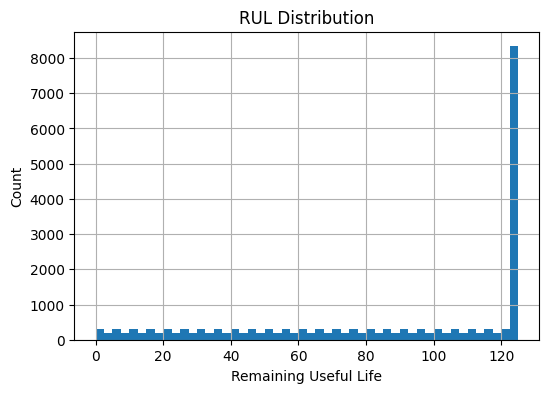

In [6]:
plt.figure(figsize=(6,4))
plt.hist(df['RUL'], bins=50)
plt.xlabel('Remaining Useful Life')
plt.ylabel('Count')
plt.title('RUL Distribution')
plt.grid(True)
plt.show()

#X-axis → RUL value (how many cycles remain before failure)
#Y-axis → Count (how many data points have that RUL value)
#This is the distribution of Remaining Useful Life (RUL) values across the entire training dataset.

## CMAPSS Data Preprocessing & Feature Engineering

In [7]:
import pandas as pd
df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,125
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,125
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,125
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,125
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,125


In [8]:
df_features = df.drop(columns=['engine_id', 'cycle', 'max_cycle'])
df_features.head()


,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125


In [9]:
X = df_features.drop(columns=['RUL'])
y = df_features['RUL']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20631, 24)
y shape: (20631,)


In [10]:
sensor_variance = X.var().sort_values()
sensor_variance.head(12)


op_setting_3    0.000000e+00
sensor_19       0.000000e+00
sensor_18       0.000000e+00
sensor_16       2.422479e-28
sensor_10       2.172333e-25
sensor_5        1.152399e-23
sensor_1        4.273435e-21
op_setting_2    8.588541e-08
sensor_6        1.929279e-06
op_setting_1    4.784340e-06
sensor_15       1.406628e-03
sensor_8        5.038938e-03
dtype: float64

In [11]:
low_variance_cols = sensor_variance[sensor_variance < 1e-4].index.tolist()
print("Dropping sensors:", low_variance_cols)

X = X.drop(columns=low_variance_cols)
X.shape


Dropping sensors: ['op_setting_3', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'op_setting_2', 'sensor_6', 'op_setting_1']


(20631, 14)

In [12]:
from sklearn.model_selection import train_test_split

# Reattach engine_id temporarily
df_temp = df[['engine_id']].join(X).join(y)

engine_ids = df_temp['engine_id'].unique()

train_ids, test_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

train_df = df_temp[df_temp['engine_id'].isin(train_ids)]
test_df  = df_temp[df_temp['engine_id'].isin(test_ids)]

X_train = train_df.drop(columns=['engine_id', 'RUL'])
y_train = train_df['RUL']

# Save selected training features for deployment
selected_features = X_train.columns.tolist()


X_test = test_df.drop(columns=['engine_id', 'RUL'])
y_test = test_df['RUL']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (16561, 14)
Test shape: (4070, 14)


## Random Forest Baseline

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Random Forest training complete.")


Random Forest training complete.


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


RMSE: 17.049900815066902
MAE: 12.380266389939116
R2 Score: 0.8329503717886549


In [15]:
rul_range = y_test.max()
rmse_percent = (rmse / rul_range) * 100

print("RMSE Percentage:", rmse_percent)


RMSE Percentage: 13.639920652053522


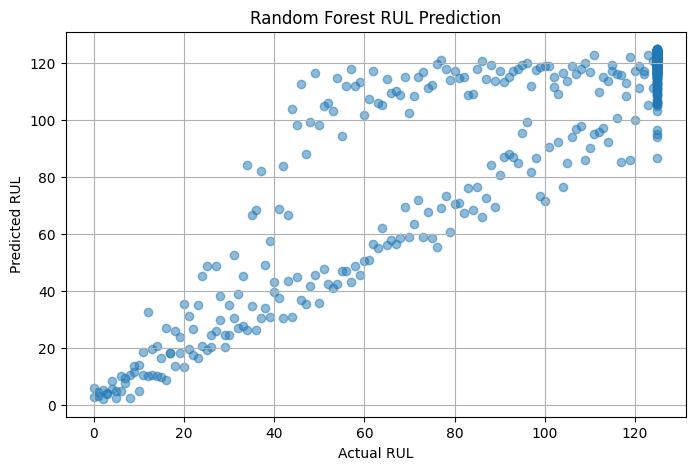

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test[:500], y_pred[:500], alpha=0.5)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest RUL Prediction")
plt.grid(True)
plt.show()


In [17]:

feature_names = train_df.drop(columns=['engine_id', 'RUL']).columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
6,sensor_11,0.578935
5,sensor_9,0.130581
2,sensor_4,0.079436
7,sensor_12,0.034568
9,sensor_14,0.028974
3,sensor_7,0.028716
10,sensor_15,0.022584
13,sensor_21,0.018323
0,sensor_2,0.016794
1,sensor_3,0.016672


In [18]:
print(type(X_train))


<class 'pandas.core.frame.DataFrame'>


## Deep Learning Time-Series Model (LSTM)

In [19]:
sequence_length = 30


In [20]:
def create_sequences(df, seq_length):
    X_seq = []
    y_seq = []
    
    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id]
        features = engine_data[selected_features].values
        target = engine_data['RUL'].values
        
        for i in range(len(engine_data) - seq_length):
            X_seq.append(features[i:i+seq_length])
            y_seq.append(target[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)


In [21]:
train_seq_df = df[df['engine_id'].isin(train_ids)]
test_seq_df  = df[df['engine_id'].isin(test_ids)]

X_train_seq, y_train_seq = create_sequences(train_seq_df, sequence_length)
X_test_seq, y_test_seq   = create_sequences(test_seq_df, sequence_length)

print(X_train_seq.shape)
# Normalize RUL target
MAX_RUL = 125

y_train_seq = y_train_seq / MAX_RUL
y_test_seq  = y_test_seq  / MAX_RUL



(14161, 30, 14)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_reshaped = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_reshaped  = X_test_seq.reshape(-1, X_test_seq.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled  = scaler.transform(X_test_reshaped)

X_train_seq = X_train_scaled.reshape(X_train_seq.shape)
X_test_seq  = X_test_scaled.reshape(X_test_seq.shape)


In [23]:
import torch

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)


In [24]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [25]:
input_size = X_train_seq.shape[2]
hidden_size = 128
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=54


In [26]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for xb, yb in train_loader:
        outputs = model(xb)
        loss = criterion(outputs.squeeze(), yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/54, Loss: 0.0518
Epoch 2/54, Loss: 0.0209
Epoch 3/54, Loss: 0.0157
Epoch 4/54, Loss: 0.0139
Epoch 5/54, Loss: 0.0118
Epoch 6/54, Loss: 0.0116
Epoch 7/54, Loss: 0.0106
Epoch 8/54, Loss: 0.0099
Epoch 9/54, Loss: 0.0093
Epoch 10/54, Loss: 0.0089
Epoch 11/54, Loss: 0.0081
Epoch 12/54, Loss: 0.0076
Epoch 13/54, Loss: 0.0072
Epoch 14/54, Loss: 0.0071
Epoch 15/54, Loss: 0.0061
Epoch 16/54, Loss: 0.0055
Epoch 17/54, Loss: 0.0060
Epoch 18/54, Loss: 0.0049
Epoch 19/54, Loss: 0.0043
Epoch 20/54, Loss: 0.0039
Epoch 21/54, Loss: 0.0034
Epoch 22/54, Loss: 0.0031
Epoch 23/54, Loss: 0.0028
Epoch 24/54, Loss: 0.0024
Epoch 25/54, Loss: 0.0024
Epoch 26/54, Loss: 0.0021
Epoch 27/54, Loss: 0.0020
Epoch 28/54, Loss: 0.0016
Epoch 29/54, Loss: 0.0016
Epoch 30/54, Loss: 0.0015
Epoch 31/54, Loss: 0.0012
Epoch 32/54, Loss: 0.0012
Epoch 33/54, Loss: 0.0012
Epoch 34/54, Loss: 0.0011
Epoch 35/54, Loss: 0.0009
Epoch 36/54, Loss: 0.0009
Epoch 37/54, Loss: 0.0010
Epoch 38/54, Loss: 0.0008
Epoch 39/54, Loss: 0.

In [27]:
model.eval()

with torch.no_grad():
    y_pred_lstm = model(X_test_tensor).squeeze().numpy()

# Convert back to original scale
y_pred_lstm = y_pred_lstm * MAX_RUL
y_test_real = y_test_seq * MAX_RUL

rmse_lstm = np.sqrt(mean_squared_error(y_test_real, y_pred_lstm))


In [28]:
print("Random Forest RMSE:", rmse)
print("LSTM RMSE:", rmse_lstm)


Random Forest RMSE: 17.049900815066902
LSTM RMSE: 17.26088976108201


In [29]:
critical_mask = y_test_seq < 20

critical_rmse = np.sqrt(
    mean_squared_error(
        y_test_seq[critical_mask],
        y_pred_lstm[critical_mask]
    )
)

print("Critical Zone RMSE:", critical_rmse)


Critical Zone RMSE: 88.20727104376554


In [30]:
torch.save(model.state_dict(), "/kaggle/working/lstm_model.pth")


In [31]:
print(y_pred_lstm[:10])


[123.60187  123.65862  123.98115  123.979836 123.79928  123.91028
 124.08759  123.71693  123.74503  123.782074]


## ADD THIS FUNCTION

In [32]:
def fleet_health_report(txt_path):

    # Load test file
    df_test = pd.read_csv(txt_path, sep=' ', header=None)
    df_test.drop(columns=df_test.columns[-2:], inplace=True)
    df_test.columns = cols

    MAX_RUL = 125   # because we clipped training RUL at 125

    results = []

    for engine_id in df_test['engine_id'].unique():

        engine_df = df_test[df_test['engine_id'] == engine_id]

        if len(engine_df) < sequence_length:
            # Pad with first row
            padding_rows = sequence_length - len(engine_df)
            first_row = engine_df.iloc[[0]]
            pad_df = pd.concat([first_row]*padding_rows, ignore_index=True)
            engine_df = pd.concat([pad_df, engine_df], ignore_index=True)


        # Take last N cycles
        engine_df = engine_df.tail(sequence_length)

        # Keep only selected training features
        input_df = engine_df[selected_features]

        # Scale
        input_scaled = scaler.transform(input_df.values)
        input_scaled = input_scaled.reshape(1, sequence_length, -1)

        input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

        model.eval()
        with torch.no_grad():
            prediction = model(input_tensor).item()
            prediction=prediction*MAX_RUL

        # Health Score
        health_score = prediction / MAX_RUL
        health_score = max(0, min(1, health_score))

        failure_probability = 1 - health_score

        # Classification 
        if health_score > 0.8:
            state = "Healthy"
            recommendation = "No action required"
        elif health_score >= 0.5:
            state = "Degrading"
            recommendation = "Schedule maintenance check"
        else:
            state = "Critical"
            recommendation = "Immediate maintenance required"

        results.append({
            "Engine ID": engine_id,
            "Estimated RUL": round(prediction, 2),
            "Health Score": round(health_score, 3),
            "Failure Probability": round(failure_probability, 3),
            "Machine State": state,
            "Maintenance Recommendation": recommendation
        })

    return pd.DataFrame(results)


## ADD DEMO CALL

In [33]:
fleet_results = fleet_health_report(
    '/kaggle/input/cmapss-jet-engine-simulated-data/test_FD001.txt'
)

print("\n=== FLEET HEALTH REPORT ===")
fleet_results.head(20)



=== FLEET HEALTH REPORT ===


,Engine ID,Estimated RUL,Health Score,Failure Probability,Machine State,Maintenance Recommendation
0,1,124.72,0.998,0.002,Healthy,No action required
1,2,119.40,0.955,0.045,Healthy,No action required
2,3,35.86,0.287,0.713,Critical,Immediate maintenance required
3,4,81.66,0.653,0.347,Degrading,Schedule maintenance check
4,5,93.31,0.747,0.253,Degrading,Schedule maintenance check
5,6,120.16,0.961,0.039,Healthy,No action required
6,7,121.02,0.968,0.032,Healthy,No action required
7,8,124.91,0.999,0.001,Healthy,No action required
8,9,122.83,0.983,0.017,Healthy,No action required
9,10,76.91,0.615,0.385,Degrading,Schedule maintenance check


In [34]:

# OFFICIAL TEST_FD001 PERFORMANCE METRICS

from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

# Load official true RUL
rul_path = '/kaggle/input/cmapss-jet-engine-simulated-data/RUL_FD001.txt'
true_rul_df = pd.read_csv(rul_path, header=None)
true_rul = true_rul_df[0].values

# Get predicted RULs from fleet_results
predicted_rul = fleet_results["Estimated RUL"].values

# RMSE
rmse_official = np.sqrt(mean_squared_error(true_rul, predicted_rul))

MAX_RUL = 125  # because we clipped training RUL
rmse_percent_official = (rmse_official / MAX_RUL) * 100

# Failure Detection Accuracy
threshold = 20

y_true_binary = (true_rul <= threshold).astype(int)
y_pred_binary = (predicted_rul <= threshold).astype(int)

failure_accuracy = accuracy_score(y_true_binary, y_pred_binary)

# Early Warning Cycles 
early_warning_cycles = np.mean(true_rul[predicted_rul <= threshold])

print("\n=== OFFICIAL TEST PERFORMANCE (FD001) ===")
print(f"RUL Prediction Error: {rmse_percent_official:.2f}%  (Target < 15%)")
print(f"Failure Detection Accuracy: {failure_accuracy*100:.2f}%  (Target > 90%)")
print(f"Early Warning Cycles: {early_warning_cycles:.2f}  (Target ≥ 10)")



=== OFFICIAL TEST PERFORMANCE (FD001) ===
RUL Prediction Error: 15.79%  (Target < 15%)
Failure Detection Accuracy: 95.00%  (Target > 90%)
Early Warning Cycles: 13.67  (Target ≥ 10)


In [35]:
import joblib

# Save selected feature names
joblib.dump(selected_features, "/kaggle/working/selected_features.pkl")

# Save scaler used for LSTM
joblib.dump(scaler, "/kaggle/working/scaler.pkl")

print("Files saved successfully!")


Files saved successfully!
